# **RANDOM CLASSIFICATION TO TEST MODEL ROBUSTNESS**

## Loading Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import warnings

from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [2]:
cols = ['fileName','noun','fake','size','start','end']
indexer = pd.DataFrame(columns=cols)
df = pd.DataFrame(columns=range(1024))
listNouns = ['article','beard','blood','company','death','gun','id','interview','passport']
#Load NOUN datasets
for noun in listNouns:
    arrF = np.load('ELMOfiles/'+noun+'FAKE.npy')
    arrNF = np.load('ELMOfiles/'+noun+'.npy')
    
    count=len(df)
    df = df.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,True,arrF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    count=len(df)
    df = df.append(pd.DataFrame(arrNF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'.npy',noun,False,arrNF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    print("loaded for "+noun)

#-------------------------------------------------------------------------[FAKE]_NOUN_
#Define a dataframe that contains embeddings with FAKE
priv = ['beard','blood','company','death','gun']
indexer.insert(loc=3,column='privative',value=False)
for index, row in indexer.iterrows():
    if row['noun'] in priv:
        indexer.at[index,'privative']= True
        
priv_fakes_idx = indexer[(indexer.fake) & (indexer.privative)]
non_priv_fakes_idx = indexer[(indexer.fake==True) & (indexer.privative==False)]

fake_nouns = pd.DataFrame(columns=range(1024))
for index, row in indexer[indexer['fake']].iterrows():
    fake_nouns=fake_nouns.append(df.loc[row['start']:row['end']])

#affine this dataframe : add a 'priv' column
if 'priv' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['priv'])
    
fake_nouns.insert(loc=1024,column='priv',value=-1)
for index, row in priv_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'priv']= 1

#add 'noun' column
if 'noun' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['noun'])
    
fake_nouns.insert(loc=1024,column='noun',value='')
for index, row in indexer[indexer['fake']].iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'noun']= row['noun']

targets_Fnouns = fake_nouns['priv']
nouns_Fnouns = fake_nouns['noun']
X_Fnouns = fake_nouns.drop(columns=['priv','noun'])

#---------------------------------------------------------------------[NOT FAKE]_NOUN_
not_fake_nouns = pd.DataFrame(columns=range(1024))

priv_not_fakes_idx = indexer[(indexer.fake==False) & (indexer.privative)]

for index, row in indexer[indexer['fake']==False].iterrows():
    not_fake_nouns=not_fake_nouns.append(df.loc[row['start']:row['end']])

if 'priv' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['priv'])
    
not_fake_nouns.insert(loc=1024,column='priv',value=-1)
for index, row in priv_not_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'priv']= 1


if 'noun' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['noun'])
    
not_fake_nouns.insert(loc=1024,column='noun',value='')
for index, row in indexer[indexer['fake']==False].iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'noun']= row['noun']

targets_NFnouns = not_fake_nouns['priv']
nouns_NFnouns = not_fake_nouns['noun']
X_NFnouns = not_fake_nouns.drop(columns=['priv','noun'])

loaded for article
loaded for beard
loaded for blood
loaded for company
loaded for death
loaded for gun
loaded for id
loaded for interview
loaded for passport


In [3]:
cols = ['fileName','noun','size','start','end']
indexer_fakes = pd.DataFrame(columns=cols)
fakes_embd = pd.DataFrame(columns=range(1024))

for noun in listNouns:
    arrF = np.load('ELMOfiles/FAKE'+noun+'FAKE.npy')
    count=len(fakes_embd)
    fakes_embd = fakes_embd.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,arrF.shape[0],count,len(fakes_embd)-1]],columns=cols)
    indexer_fakes = indexer_fakes.append(d_temp,ignore_index=True)
    
    print("done for "+noun)
    
fakes_embd.index = X_Fnouns.index #re-indexing

if 'priv' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['priv'])
    
fakes_embd.insert(loc=1024,column='priv',value=fake_nouns['priv'])

if 'noun' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['noun'])
    
fakes_embd.insert(loc=1024,column='noun',value=fake_nouns['noun'])

targets_fakes = fakes_embd['priv']
nouns_fakes = fakes_embd['noun']
X_fakes = fakes_embd.drop(columns=['priv','noun'])

done for article
done for beard
done for blood
done for company
done for death
done for gun
done for id
done for interview
done for passport


In [4]:
# We extract 10% of the not_fake NOUNS dataset because it is too big for computations
not_fake_samples = not_fake_nouns.loc[not_fake_nouns.sample(int(len(not_fake_nouns)/10)).index.sort_values()]
#The preservation of class (nouns) proportions is ensured by the size of the sample (around 8700 items)
targets_nfs = not_fake_samples['priv']
nouns_nfs = not_fake_samples['noun']
X_nfs = not_fake_samples.drop(columns=['priv','noun'])
not_fake_samples

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,noun,priv
84,-0.091092,0.188746,-0.065995,0.443621,-0.117619,-0.364823,0.495717,0.694802,0.453884,0.474091,...,-0.219109,0.051547,-0.133077,0.139407,-0.214463,0.238882,-0.781349,-0.796514,article,-1
89,1.131557,-0.499294,0.607651,-0.149377,-0.325199,-0.745183,1.146810,0.881280,1.031308,0.876145,...,0.452967,-0.078413,0.101102,0.143147,-0.069196,0.205493,-0.507892,-0.204184,article,-1
91,0.078200,0.086143,0.531119,-0.205212,-0.089739,0.213160,0.803262,0.681694,0.269135,-0.423637,...,0.303617,-0.177410,-0.286402,-0.165123,-0.174212,-0.078653,-1.016672,-0.374268,article,-1
92,-0.132614,-0.020371,0.474976,0.027817,-0.512490,-0.075253,0.713877,0.689311,0.479944,-0.043369,...,0.304163,-0.152681,-0.265775,-0.145122,-0.220297,-0.065975,-1.058731,-0.408177,article,-1
120,1.110241,-0.489777,0.607153,-0.162908,-0.321185,-0.735911,1.124815,0.873647,1.034272,0.870598,...,0.903967,-0.339857,0.327561,0.272399,-0.171909,-0.269421,-0.505009,-0.512767,article,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87389,-0.259639,0.675403,0.614266,0.107698,0.168343,-0.186715,0.181773,0.554251,0.736555,0.067501,...,1.063185,-0.566348,0.426971,-0.223625,0.072306,-0.683263,-0.129778,0.102934,passport,-1
87399,-0.410129,-0.193692,-0.096851,0.249811,0.444895,0.353785,0.866888,-0.018872,0.490662,-0.107222,...,0.223490,-1.024003,0.361570,0.157017,0.030069,0.208881,-0.393505,0.311896,passport,-1
87433,-0.224676,0.092087,-0.034056,0.155788,0.262891,0.314452,0.043448,0.922981,0.718686,-0.409468,...,0.814687,-0.950302,0.271851,-0.495991,-0.035338,-0.754557,-0.475343,-0.249594,passport,-1
87435,-0.370427,-0.338356,-0.511273,-0.511436,-0.594989,0.599724,0.747018,0.942418,0.631193,-0.174618,...,0.571117,-0.807095,0.560608,-0.190731,-0.242999,-0.933339,-0.113498,0.500603,passport,-1


In [7]:
nouns_NFnouns.value_counts()

blood        11395
gun          11091
company      10802
article      10392
death        10323
interview    10133
id            9723
passport      9247
beard         3752
Name: noun, dtype: int64

## Datasets storage reminder : 
* [fake] **NOUN** : fake_nouns ; indexer ; X_Fnouns ; targets_Fnouns ; nouns_Fnouns
* [not fake] **NOUN** : not_fake_nouns ; indexer ; X_NFnouns ; targets_NFnouns ; nouns_NFnouns
* **sampled** [not fake] **NOUN** : not_fake_samples ; - ; X_nfs ; targets_nfs ; nouns_nfs
* **FAKE** : fakes_embd ; indexer_fakes ; X_fakes ; targets_fakes ; nouns_fakes

## Random Sampling

In [5]:
def random_labeling(tolerance,df,debug=False,rng=None,out_list=False):
    delta = tolerance*2
    while delta > tolerance:
        if rng:
            rand_classes = {listNouns[k]:rng.integers(0,2) for k in range(9)}
        else:
            rand_classes = {listNouns[k]:np.random.randint(2) for k in range(9)}
        rand_targets = pd.Series(data=np.ones(len(df))*-1,index=df.index)
        for i, embd in df.iterrows():
            if rand_classes[embd['noun']]==1:
                rand_targets[i]=1
        delta = np.abs(rand_targets.sum())
    if debug:
        print('sampling delta : ', delta)
        print(rand_targets.value_counts())
    if out_list:
        return (rand_targets, rand_classes)
    else:
        return rand_targets

sampling delta :  35.0
-1.0    317
 1.0    282
dtype: int64


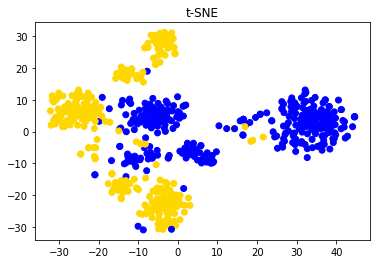

In [6]:
rand_targets = random_labeling(50,fakes_embd,True)
tsneX = TSNE(n_components=2, init='pca', random_state=0)
X_trans = tsneX.fit_transform(X_fakes).T

colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_trans[0], X_trans[1], color=rand_targets.map(colors_classes))
plt.title("t-SNE")
plt.axis('tight')
plt.show()

## Functions to test robustness

### Banned Noun Classification (BNC)

In [7]:
def Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess=None,k=2,show_kbest=False):
    if preprocess=='pca':
        model = make_pipeline(Scaler(),PCA(n_components=0.975),classifier)
    else:
        model = classifier
    model.fit(Xtrain,Ttrain)
    y_train = model.predict(Xtrain)
    Tacc = np.sum(Ttrain == y_train)/len(Xtrain)
    y_banned = model.predict(Xbanned)
    Bacc = np.sum(Tbanned == y_banned)/len(Xbanned)
    return (Tacc,Bacc)

def BNC_accuracy(classifier,X,targets,nouns,preprocess=None,k=2,full_output=False,debug=False,show_kbest=False):
    if debug:
        print("\rTest {} : BNC  starting%                     ".format(debug), end="")
        sys.stdout.flush()
    Taccs = np.zeros(len(listNouns))
    Baccs = np.zeros(len(listNouns))
    if preprocess=='kbest global':
        select = SelectKBest(MIC,k).fit(X,targets)
        X = Scaler().fit_transform(select.transform(X))
        if show_kbest:
            print("\r{}     ".format(np.where(select.get_support())[0]),end="")
    for i,bannedW in enumerate(listNouns):
        if debug:
            print("\rTest {} : BNC for {} ; {}%             ".format(debug, bannedW, 100 * i // len(listNouns)), end="")
            sys.stdout.flush()
        Xtrain = X[nouns!=bannedW]
        Ttrain = targets[nouns!=bannedW]
        if preprocess=='kbest local':
            select = SelectKBest(MIC,k).fit(Xtrain,Ttrain)
            scalr = Scaler()
            Xtrain = scalr.fit_transform(select.transform(Xtrain))
            if show_kbest:
                print("({})".format(np.where(select.get_support())[0]))
        Xbanned = X[nouns==bannedW]
        if preprocess == 'kbest local':
            Xbanned = scalr.transform(select.transform(Xbanned))
        Tbanned = targets[nouns==bannedW]
        Tacc,Bacc = Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess,k,show_kbest)
        Taccs[i],Baccs[i] = Tacc, Bacc
    AvgTrain = np.mean(Taccs)
    AvgBanned = np.mean(Baccs)
    if full_output:
        return (Taccs,Baccs)
    else:
        return (AvgTrain,AvgBanned)

### Classical Train/Test split and classification

In [8]:
def classical_accuracy(classifier,X,targets,nouns,preprocess=None,k=2,out_model=False):
    #model selection
    if preprocess=='pca':
        model = make_pipeline(Scaler(),PCA(n_components=0.975),classifier)
    elif preprocess=='kbest local' or preprocess=='kbest global':
        model = make_pipeline(SelectKBest(MIC,k),Scaler(),classifier)
    else:
        model = classifier
    #The training set should be balanced in term of repartition of nouns
    Xtrain,Xtest,Ttrain,Ttest =train_test_split(X, targets, test_size=0.25, random_state=0, stratify=nouns,shuffle=True)
    #model training and predictions
    model.fit(Xtrain,Ttrain)
    y_train = model.predict(Xtrain)
    y_test = model.predict(Xtest)
    #accuracies
    Train_acc = np.sum(Ttrain == y_train)/len(Xtrain)
    Test_acc = np.sum(Ttest == y_test)/len(Xtest)
    if out_model:
        return (Train_acc,Test_acc,model)
    else:
        return (Train_acc,Test_acc)

In [9]:
priv = ['beard','blood','company','death','gun']
non_priv = ['article','id','interview','passport']

In [10]:
delta_not_fake = np.sum(nouns_nfs.value_counts()[priv])-np.sum(nouns_nfs.value_counts()[non_priv])
delta_fake = np.abs(np.sum(nouns_fakes.value_counts()[priv])-np.sum(nouns_fakes.value_counts()[non_priv]))
print('% of original unbalancing : {}% in NOT FAKE ; {}% in FAKE'.format(delta_not_fake*100//len(nouns_nfs), delta_fake*100//len(nouns_fakes)))

% of original unbalancing : 9% in NOT FAKE ; 3% in FAKE


In [11]:
datasets = {'FAKES': [fakes_embd, X_fakes,targets_fakes, nouns_fakes],
            'fake NOUNS': [fake_nouns, X_Fnouns, targets_Fnouns, nouns_Fnouns],
            'not fake NOUNS': [not_fake_samples, X_nfs, targets_nfs, nouns_nfs]
           }
nb_tests = 8

In [12]:
def random_classif_process(classifier,clf_name,nb_tests,preprocess=None,k=2):
    print("============================================ {} =============================================".format(clf_name.upper()))
    for category in datasets.keys():
        print('--------------------------{}--------------------------'.format(category))
        embeddings,X,T,N = datasets[category]
        if preprocess=='tsne':
            tsne = TSNE(n_components=k)
            X = tsne.fit_transform(X)
        Taccs, Gaccs = np.zeros((2,nb_tests))
        BNC_Taccs, Baccs = np.zeros((2,nb_tests))
        for i in range(nb_tests):
            print("\rTest {} : random sampling            ".format(i+1), end="")
            sys.stdout.flush()
            rand_T = random_labeling(int(len(embeddings)*0.09),embeddings) #we have a tolerance of 9% the size of the dataset, since it is the difference maximum we observed in the original class repartition
            print("\rTest {} : random classif              ".format(i+1), end="")
            sys.stdout.flush()
            Taccs[i], Gaccs[i] = classical_accuracy(classifier,X,rand_T,N,preprocess=preprocess,k=k)
            BNC_Taccs[i], Baccs[i] = BNC_accuracy(classifier,X,rand_T,N,preprocess=preprocess,k=k,debug=i+1)
        print('\rAverage train accuracy : {}%   ( {}  )'.format(np.mean(Taccs).round(4)*100,np.std(Taccs).round(4)*100))
        print('Average test accuracy : {}%   ( {}  )'.format(np.mean(Gaccs).round(4)*100,np.std(Gaccs).round(4)*100))
        print('\rAverage BNC train accuracy : {}%   ( {}  )'.format(np.mean(BNC_Taccs).round(4)*100,np.std(BNC_Taccs).round(4)*100))
        print('Average BNC test accuracy : {}%   ( {}  )'.format(np.mean(Baccs).round(4)*100,np.std(Baccs).round(4)*100))

## Random Classif for RAW DATA

In [29]:
random_classif_process(LinearSVC(max_iter=100000),'linear SVM',8)

============================================ LINEAR SVM =============================================
--------------------------FAKES--------------------------
Average train accuracy : 100.0%   ( 0.0  )   
Average test accuracy : 99.25%   ( 0.0091  )
Average BNC train accuracy : 100.0%   ( 0.0  )
Average BNC test accuracy : 41.99%   ( 0.0363  )
--------------------------fake NOUNS--------------------------
Average train accuracy : 100.0%   ( 0.0  )   
Average test accuracy : 100.0%   ( 0.0  )
Average BNC train accuracy : 100.0%   ( 0.0  )
Average BNC test accuracy : 44.57%   ( 0.1531  )
--------------------------not fake NOUNS--------------------------
Average train accuracy : 100.0%   ( 0.0  )   
Average test accuracy : 100.0%   ( 0.0  )
Average BNC train accuracy : 100.0%   ( 0.0  )
Average BNC test accuracy : 46.85%   ( 0.0946  )


In [367]:
random_classif_process(SVC(kernel='rbf'),'rbf SVM',8)

============================================ RBF SVM =============================================
--------------------------FAKES--------------------------
Average train accuracy : 99.5%%              
Average test accuracy : 98.58%
Average BNC train accuracy : 99.65%
Average BNC test accuracy : 45.08%
--------------------------fake NOUNS--------------------------
Average train accuracy : 100.0%              
Average test accuracy : 100.0%
Average BNC train accuracy : 100.0%
Average BNC test accuracy : 35.0%
--------------------------not fake NOUNS--------------------------
Average train accuracy : 100.0%              
Average test accuracy : 100.0%
Average BNC train accuracy : 100.0%
Average BNC test accuracy : 43.51%


## Random Classif for PCA DATA

In [369]:
random_classif_process(LinearSVC(max_iter=100000),'linear SVM',8,preprocess='pca')

============================================ LINEAR SVM =============================================
--------------------------FAKES--------------------------
Average train accuracy : 100.0%              
Average test accuracy : 98.58%
Average BNC train accuracy : 100.0%
Average BNC test accuracy : 40.410000000000004%
--------------------------fake NOUNS--------------------------
Average train accuracy : 100.0%              
Average test accuracy : 100.0%
Average BNC train accuracy : 100.0%
Average BNC test accuracy : 45.15%
--------------------------not fake NOUNS--------------------------
Average train accuracy : 100.0%              
Average test accuracy : 100.0%
Average BNC train accuracy : 100.0%
Average BNC test accuracy : 41.18%


In [370]:
random_classif_process(SVC(kernel='rbf'),'rbf SVM',8,preprocess='pca')

============================================ RBF SVM =============================================
--------------------------FAKES--------------------------
Average train accuracy : 100.0%              
Average test accuracy : 99.25%
Average BNC train accuracy : 99.99%
Average BNC test accuracy : 33.03%
--------------------------fake NOUNS--------------------------
Average train accuracy : 100.0%              
Average test accuracy : 100.0%
Average BNC train accuracy : 100.0%
Average BNC test accuracy : 38.769999999999996%
--------------------------not fake NOUNS--------------------------
Average train accuracy : 100.0%              
Average test accuracy : 100.0%
Average BNC train accuracy : 100.0%
Average BNC test accuracy : 36.29%


## Random Classif for T-SNE DATA

In [58]:
warnings.filterwarnings('ignore') #ignore ConvergenceWarnings
random_classif_process(LinearSVC(max_iter=100000),'linear SVM',8,preprocess='tsne',k=2)
warnings.filterwarnings('default')

============================================ LINEAR SVM =============================================
--------------------------FAKES--------------------------
Average train accuracy : 78.97999999999999%   ( 9.27  )
Average test accuracy : 80.17%   ( 8.58  )
Average BNC train accuracy : 80.93%   ( 6.43  )
Average BNC test accuracy : 50.14999999999999%   ( 14.21  )
--------------------------fake NOUNS--------------------------
Average train accuracy : 78.45%   ( 13.459999999999999  )
Average test accuracy : 78.75%   ( 13.36  )
Average BNC train accuracy : 82.39%   ( 9.790000000000001  )
Average BNC test accuracy : 49.74%   ( 23.150000000000002  )
--------------------------not fake NOUNS--------------------------
Average train accuracy : 66.71000000000001%   ( 13.600000000000001  )
Average test accuracy : 66.61%   ( 13.61  )
Average BNC train accuracy : 71.37%   ( 11.450000000000001  )
Average BNC test accuracy : 34.239999999999995%   ( 24.18  )


In [383]:
random_classif_process(SVC(kernel='rbf'),'rbf SVM',8,preprocess='tsne',k=2)

============================================ RBF SVM =============================================
--------------------------FAKES--------------------------
Average train accuracy : 94.52000000000001%  
Average test accuracy : 95.67%
Average BNC train accuracy : 95.35%
Average BNC test accuracy : 47.97%
--------------------------fake NOUNS--------------------------
Average train accuracy : 99.69%              
Average test accuracy : 99.67%
Average BNC train accuracy : 99.95%
Average BNC test accuracy : 42.18%
--------------------------not fake NOUNS--------------------------
Average train accuracy : 99.9%%              
Average test accuracy : 99.94%
Average BNC train accuracy : 99.95%
Average BNC test accuracy : 38.550000000000004%


## Random Classif for KBest-Selected (2) DATA

Local setting of the Feature selection (1 per BNC step)

In [140]:
warnings.filterwarnings('ignore') #ignore FutureWarnings
random_classif_process(LinearSVC(max_iter=100000),'linear SVM',8,preprocess='kbest local',k=2)
warnings.filterwarnings('default')

============================================ LINEAR SVM =============================================
--------------------------FAKES--------------------------
Test 1 : BNC for passport ; 88%              

KeyboardInterrupt: 

Global setting of the Feature selection (1 for all the BNC)

In [505]:
warnings.filterwarnings('ignore') #ignore FutureWarnings
random_classif_process(LinearSVC(max_iter=100000),'linear SVM',8,preprocess='kbest global',k=2)
warnings.filterwarnings('default')

============================================ LINEAR SVM =============================================
--------------------------FAKES--------------------------
Average train accuracy : 82.43%              
Average test accuracy : 83.67%
Average BNC train accuracy : 83.46000000000001%
Average BNC test accuracy : 68.65%
--------------------------fake NOUNS--------------------------
Average train accuracy : 91.34%              
Average test accuracy : 89.33%
Average BNC train accuracy : 91.47999999999999%
Average BNC test accuracy : 81.22%
--------------------------not fake NOUNS--------------------------
Average train accuracy : 88.07000000000001%  
Average test accuracy : 88.17%
Average BNC train accuracy : 88.27000000000001%
Average BNC test accuracy : 84.23%


In [ ]:
warnings.filterwarnings('ignore') #ignore FutureWarnings
random_classif_process(SVC(kernel='rbf'),'rbf SVM',8,preprocess='kbest local',k=2)
warnings.filterwarnings('default')

## Random Classif for KBest-Selected (10) DATA

In [387]:
warnings.filterwarnings('ignore') #ignore FutureWarnings
random_classif_process(LinearSVC(max_iter=100000),'linear SVM',8,preprocess='kbest local',k=10)
warnings.filterwarnings('default')

============================================ LINEAR SVM =============================================
--------------------------FAKES--------------------------
Average train accuracy : 91.82000000000001%  
Average test accuracy : 90.08%
Average BNC train accuracy : 93.13%
Average BNC test accuracy : 42.47%
--------------------------fake NOUNS--------------------------
Average train accuracy : 99.42%              
Average test accuracy : 99.25%
Average BNC train accuracy : 99.67%
Average BNC test accuracy : 54.21%
--------------------------not fake NOUNS--------------------------
Average train accuracy : 97.41%              
Average test accuracy : 97.68%
Average BNC train accuracy : 98.31%
Average BNC test accuracy : 45.910000000000004%


In [ ]:
warnings.filterwarnings('ignore') #ignore FutureWarnings
random_classif_process(SVC(kernel='rbf'),'rbf SVM',8,preprocess='kbest local',k=10)
warnings.filterwarnings('default')

## Visualization of a random classification

We will use FAKE embeddings

In [535]:
# # Looking for a random key that output the original separation
# privativity_dict = {'article': 0, 'beard': 1, 'blood': 1, 'company': 1, 'death': 1, 'gun': 1, 'id': 0, 'interview': 0, 'passport': 0}
# non_privativity_dict = {n:0**privativity_dict[n] for n in privativity_dict}

# i=0
# rng = np.random.default_rng(i)
# rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)

# while rand_dict != privativity_dict and rand_dict != non_privativity_dict:
#     i+=1
#     rng = np.random.default_rng(i)
#     rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)
# print(i)

In [13]:
warnings.filterwarnings('ignore') #ignore FutureWarnings

{'article': 0, 'beard': 0, 'blood': 1, 'company': 1, 'death': 0, 'gun': 1, 'id': 0, 'interview': 0, 'passport': 1}


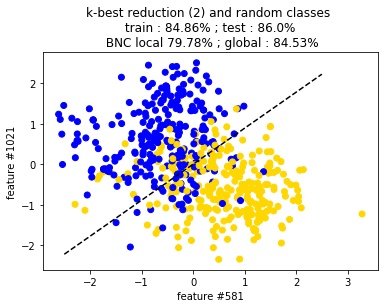

In [43]:
rng = np.random.default_rng(42) #set 26 to get original class division

#Choose if you want a controlled rng or not
#rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)
rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,out_list=True)

print(rand_dict)

Tacc, Gacc, model = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,rand_T,nouns_fakes,preprocess='kbest local',k=2,out_model=True)
#_, Loc_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,rand_T,nouns_fakes, preprocess='kbest local',k=2,debug=1)
#_, Gbl_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,rand_T,nouns_fakes, preprocess='kbest global',k=2,debug=1)


X_fakes_trans = model[1].transform(model[0].transform(X_fakes)).T
axes_nb = np.where(model[0].get_support())[0]

colors_classes={-1: 'blue', 1 : 'gold'}

w = model[2].coef_[0]
i = model[2].intercept_[0]
x1 = np.linspace(-2.5,2.5,10)
a = -w[0]/w[1]
x2 = a * x1 - i/w[1]
colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_fakes_trans[0], X_fakes_trans[1], color=rand_T.map(colors_classes))
plt.plot(x1,x2,'k--',label='Separation line')
plt.title("k-best reduction (2) and random classes \n train : {}% ; test : {}% \n BNC local {}% ; global : {}%".format(Tacc.round(4)*100, Gacc.round(4)*100,Loc_Bacc.round(4)*100,Gbl_Bacc.round(4)*100))
plt.axis('tight')
plt.xlabel('feature #' + str(axes_nb[0]))
plt.ylabel('feature #' + str(axes_nb[1]))
plt.show()

Test 1 : BNC for passport ; 88%              

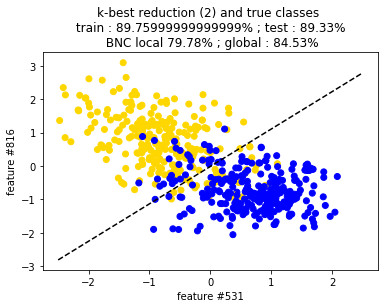

In [19]:
Tacc, Gacc, model = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes,preprocess='kbest local',k=2,out_model=True)
_, Loc_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes, preprocess='kbest local',k=2,debug=1)
_, Gbl_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes, preprocess='kbest global',k=2,debug=1)


X_fakes_trans = model[1].transform(model[0].transform(X_fakes)).T
axes_nb = np.where(model[0].get_support())[0]

colors_classes={-1: 'blue', 1 : 'gold'}

w = model[2].coef_[0]
i = model[2].intercept_[0]
x1 = np.linspace(-2.5,2.5,10)
a = -w[0]/w[1]
x2 = a * x1 - i/w[1]
colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_fakes_trans[0], X_fakes_trans[1], color=targets_fakes.map(colors_classes))
plt.plot(x1,x2,'k--',label='Separation line')
plt.title("k-best reduction (2) and true classes \n train : {}% ; test : {}% \n BNC local {}% ; global : {}%".format(Tacc.round(4)*100, Gacc.round(4)*100,Loc_Bacc.round(4)*100,Gbl_Bacc.round(4)*100))
plt.axis('tight')
plt.xlabel('feature #' + str(axes_nb[0]))
plt.ylabel('feature #' + str(axes_nb[1]))
plt.show()

In [25]:
BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes, preprocess='kbest local',k=10,debug=2,show_kbest=True)

Test 2 : BNC for article ; 0%               ([531 617 678 727 793 816 864 914 979 999])
Test 2 : BNC for beard ; 11%             ([531 616 685 816 861 864 878 897 914 985])
Test 2 : BNC for blood ; 22%             ([531 620 710 802 816 864 866 897 902 914])
Test 2 : BNC for company ; 33%             ([531 695 789 816 864 878 897 914 979 985])
Test 2 : BNC for death ; 44%             ([531 678 726 789 816 822 864 878 914 979])
Test 2 : BNC for gun ; 55%             ([531 678 816 822 864 878 897 914 979 985])
Test 2 : BNC for id ; 66%             ([531 687 745 789 816 822 840 878 985 999])
Test 2 : BNC for interview ; 77%             ([531 678 726 789 816 864 878 897 914 985])
Test 2 : BNC for passport ; 88%             ([531 678 710 740 816 866 868 878 897 979])


(0.9562665929837214, 0.823032786644227)

In [497]:
selector = SelectKBest(MIC,2)
X_trans = Scaler().fit_transform(selector.fit_transform(X_fakes,rand_T))
print("\r{}".format(np.where(selector.get_support())[0]))
BNC_accuracy(classifier,X_trans,rand_T,nouns_fakes)

[676 985]


(0.8607260725479077, 0.7250925658136687)

In [ ]:
warnings.filterwarnings('default')

## Testing all random partitions

In [14]:
warnings.filterwarnings('ignore')

In [15]:
# delta = tolerance*2
# while delta > tolerance:
#     if rng:
#         rand_classes = {listNouns[k]:rng.integers(0,2) for k in range(9)}
#     else:
#         rand_classes = {listNouns[k]:np.random.randint(2) for k in range(9)}
#     rand_targets = pd.Series(data=np.ones(len(df))*-1,index=df.index)
#     for i, embd in df.iterrows():
#         if rand_classes[embd['noun']]==1:
#             rand_targets[i]=1
#     delta = np.abs(rand_targets.sum())
# if debug:
#     print('sampling delta : ', delta)
#     print(rand_targets.value_counts())
# if out_list:
#     return (rand_targets, rand_classes)
# else:
#     return rand_targets



def partition(n):
    buffer = []
    if n==1:
        return [[0],[1]]
    sub_list=partition(n-1)
    for part in sub_list:
        buffer.append([0]+part.copy())
        buffer.append([1]+part.copy())
    return buffer

combinaisons = partition(9)

counts = nouns_fakes.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(len(fakes_embd)*0.09):
        valid_parts.append(part)
origin_ind_fakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_fakes)            
len(valid_parts)

original index :  9


88

In [16]:
# As expected, all valid partitions have also their symetric that is valid and in the reverse order.
pairs = 0
for i in range(len(valid_parts)//2):
    if valid_parts[i]==list((np.array(valid_parts[-i-1])-1)*-1):
        pairs+=1
pairs

44

In [21]:
part = valid_parts[0]

part_classes = {listNouns[k]:part[k] for k in range(9)}
part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
for i, embd in fakes_embd.iterrows():
    if part_classes[embd['noun']]==1:
        part_targets[i]=1
print(BNC_accuracy(LinearSVC(),X_fakes,part_targets,nouns_fakes,preprocess='kbest local',k=2,debug=1))

part = valid_parts[-1]
part_classes = {listNouns[k]:part[k] for k in range(9)}
part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
for i, embd in fakes_embd.iterrows():
    if part_classes[embd['noun']]==1:
        part_targets[i]=1
print(BNC_accuracy(LinearSVC(),X_fakes,part_targets,nouns_fakes,preprocess='kbest local',k=2,debug=2))


#The result is the same for a partition or its reverse ! So we does not need to count the symetric ones.

Test 1 : BNC for passport ; 88%              (0.9198580035878958, 0.5828963614163383)
Test 2 : BNC for passport ; 88%              (0.9198580035878958, 0.5828963614163383)


In [17]:
parts_to_test = valid_parts[:len(valid_parts)//2]
FAKES_classic_scores = np.empty(len(parts_to_test))
FAKES_BNC_scores = np.empty(len(parts_to_test))
FNOUNS_classic_scores = np.empty(len(parts_to_test))
FNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
    for i, embd in fakes_embd.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,FAKES_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest local',k=2)
    _,FAKES_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest local',k=2,debug=ind+1)
    _,FNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns ,preprocess='kbest local',k=2)
    _,FNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns,preprocess='kbest local',k=2,debug=ind+1)


Test 44 : BNC for passport ; 88%              

In [18]:
np.max(FAKES_BNC_scores)

0.7977901546288577

In [19]:
high_s_fakes = FAKES_BNC_scores[FAKES_BNC_scores>0.71]
highest_p_fakes = np.flip(np.argsort(FAKES_BNC_scores))[:len(high_s_fakes)]
for ind in highest_p_fakes:
    if ind == origin_ind_fakes:
        print(FAKES_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FAKES_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.7978 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7891 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.7534 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20


In [20]:
high_s_fnouns = FNOUNS_BNC_scores[FNOUNS_BNC_scores>0.71]
highest_p_fnouns = np.flip(np.argsort(FNOUNS_BNC_scores))[:len(high_s_fnouns)]
for ind in highest_p_fnouns:
    if ind == origin_ind_fakes:
        print(FNOUNS_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.9468 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7306 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.7182 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12


In [45]:
listNouns

['article',
 'beard',
 'blood',
 'company',
 'death',
 'gun',
 'id',
 'interview',
 'passport']

In [44]:
valid_parts[23]

[1, 0, 0, 0, 1, 1, 1, 0, 0]

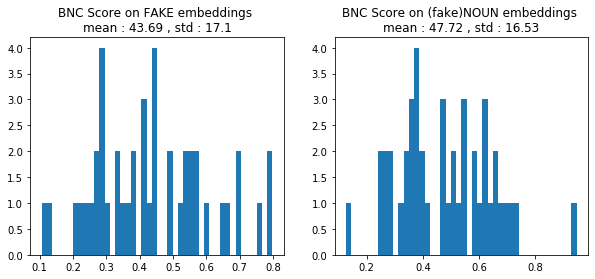

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(FAKES_BNC_scores,bins=44,density=False)
ax[1].hist(FNOUNS_BNC_scores,bins=44,density=False)
ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
plt.show()

In [22]:
np.round((np.mean(FAKES_BNC_scores),np.std(FAKES_BNC_scores)),4)

array([0.4369, 0.1713])

In [23]:
np.round((np.mean(FNOUNS_BNC_scores),np.std(FNOUNS_BNC_scores)),4)

array([0.4772, 0.1653])

In [41]:
counts = nouns_nfs.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(max(len(not_fake_samples)*0.09,targets_nfs.sum())):
        valid_parts.append(part)

origin_ind_notfakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_notfakes)

print('nb of valid partitions : ',len(valid_parts))



original index :  8
nb of valid partitions :  138


In [42]:
parts_to_test = valid_parts[:len(valid_parts)//2]
NFNOUNS_classic_scores = np.empty(len(parts_to_test))
NFNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(not_fake_samples))*-1,index=not_fake_samples.index)
    for i, embd in not_fake_samples.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,NFNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs ,preprocess='kbest local',k=2)
    _,NFNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs,preprocess='kbest local',k=2,debug=ind+1)


Test 41 : BNC for death ; 44%                 

KeyboardInterrupt: 

In [ ]:
np.max(NFNOUNS_BNC_scores)

In [ ]:
high_s_nfnouns = NFNOUNS_BNC_scores[NFNOUNS_BNC_scores>0.71]
highest_p_nfnouns = np.flip(np.argsort(NFNOUNS_BNC_scores))[:len(high_s_nfnouns)]
for ind in highest_p_nfnouns:
    if ind == origin_ind_notfakes:
        print(NFNOUNS_BNC_scores[origin_ind_notfakes].round(4) , valid_parts[origin_ind_notfakes], ' baseline (original partition)')
    else:
        print(NFNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

In [ ]:
plt.hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False)
plt.title('BNC Score on (not fake)NOUN embeddings')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(FAKES_BNC_scores,bins=len(FAKES_BNC_scores),density=False, label='{} partitions'.format(len(FAKES_BNC_scores)))
ax[1].hist(FNOUNS_BNC_scores,bins=len(FNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(FNOUNS_BNC_scores)))
ax[2].hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(NFNOUNS_BNC_scores)))

ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
ax[2].set_title('BNC Score on (not fake)NOUN embeddings \n mean : {} , std : {}'.format(np.mean(NFNOUNS_BNC_scores).round(4)*100,np.std(NFNOUNS_BNC_scores).round(4)*100))

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('random_scores.png',dpi=300)
plt.show()

In [ ]:
warnings.filterwarnings('default')